# Experiment plotting

This notebook contains the code for plotting results for several simulations.


In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import pickle
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
from lib.plot import Plotter

In [11]:
places = [('GER', 'TU'), ('GER', 'RH'), ('GER', 'KL'), ('CH', 'TI'), ('CH', 'BE'), ('CH', 'JU')]

ymax_counterfactual = {'CH' : {'TI': 5000, 'BE': 40000, 'JU': 25000},
        'GER': {'TU': 20000, 'KL': 2000, 'RH': 3500}}

ymax_modelfit = {'GER': {'TU': 1200, 'KL': 800, 'RH': 1000, 'TR': 2000,},
                 'CH': {'VD': 2000, 'BE': 600, 'TI': 500, 'JU': 500,}}

## Model fit

In [4]:
def plot_model_fit(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'model-fit-{country}-{area}' : [
            Plot(label='COVID-19 simulated case data', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
        ],
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[sims[0].country][sims[0].area]
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        end_date = calibration_lockdown_dates[sims[0].country]['end']

        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days        
        
        mob_settings_paths = calibration_mob_paths[sims[0].country][sims[0].area][1]
        with open(mob_settings_paths, 'rb') as fp:
            mob_settings = pickle.load(fp)

        area_cases = collect_data_from_df(country=country,
             area=area,
             datatype='new',
             start_date_string=start_date,
             end_date_string=end_date)

        sim_cases = downsample_cases(area_cases, mob_settings)      # only downscaling due LK data for cities

        plotter.plot_positives_vs_target(
            summaries, labels,
            sim_cases.sum(axis=1),
            title='Calibration period',
            filename=plot_filename,
            figsize=(6, 4),
            start_date=start_date,
            errorevery=1, acc=1000,
            ymax=ymax[sims[0].country][sims[0].area],
            lockdown_at=days_until_lockdown,
            lockdown_label_y=ymax[sims[0].country][sims[0].area]/4
        )


GER TU


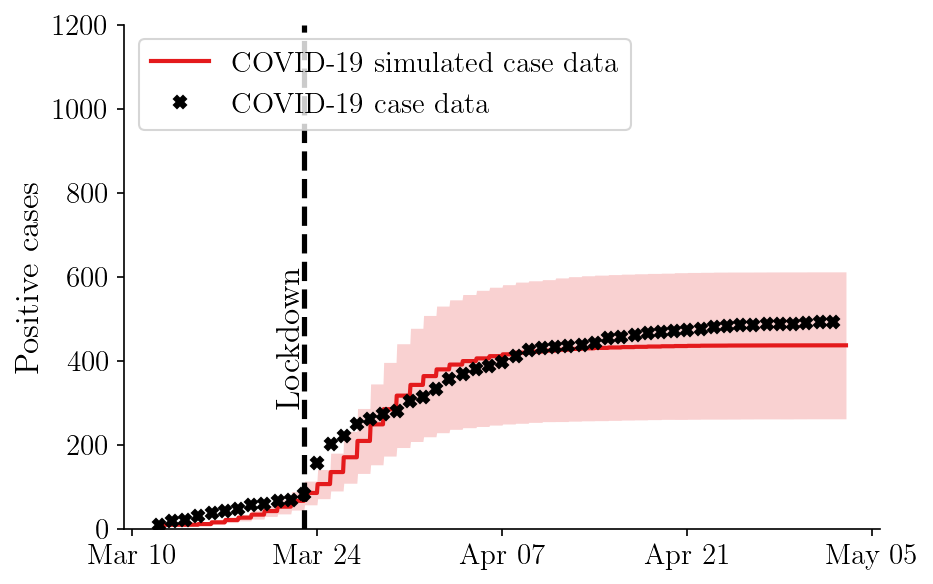

In [5]:
for country, area in places:
    print(country, area)
    plot_model_fit(country, area, ymax_modelfit)

## Continued lockdown

In [6]:
def plot_continued_lockdown(country, area, ymax, plot_rt=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'continued-lockdown-{country}-{area}' : [
            Plot(label='Baseline',
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='Open after 2 weeks', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=2.pk')),
            Plot(label='Open after 4 weeks',
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=4.pk')),
            Plot(label='Lockdown', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
        ],
    }


    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[sims[0].country][sims[0].area]
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        end_date = calibration_lockdown_dates[sims[0].country]['end']

        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=ymax[sims[0].country][sims[0].area]/5,
            legendXoffset=0.015,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)
        
        if plot_rt:
            indices = [3]    # Show Rt for the best working strategy only
        
            for idx in indices:
                plot_name = sims[idx].experiment_info
                plotter.plot_daily_rts(summaries[idx], 
                                       filename=plot_name+'-Rt', 
                                       start_date=start_date, 
                                       titles=None, 
                                       lockdown_label='Intervention',
                                       lockdown_at=days_until_lockdown, 
                                       lockdown_label_y=3, 
                                       ymax=None, 
                                       errorevery=1, 
                                       )

GER TU
Optimize sigma using maximum likelihood estimation...
 0.50: 47
 0.50: 47
 0.01: 47
 0.01: 47
 0.47: 47
 0.47: 47
 0.32: 47
 0.32: 47
 0.40: 47
 0.40: 47
 0.37: 47
 0.37: 47
 0.38: 47
 0.38: 47
 0.38: 47
 0.38: 47
 0.38: 47
 0.38: 47
done. Best sigma found at: 0.38


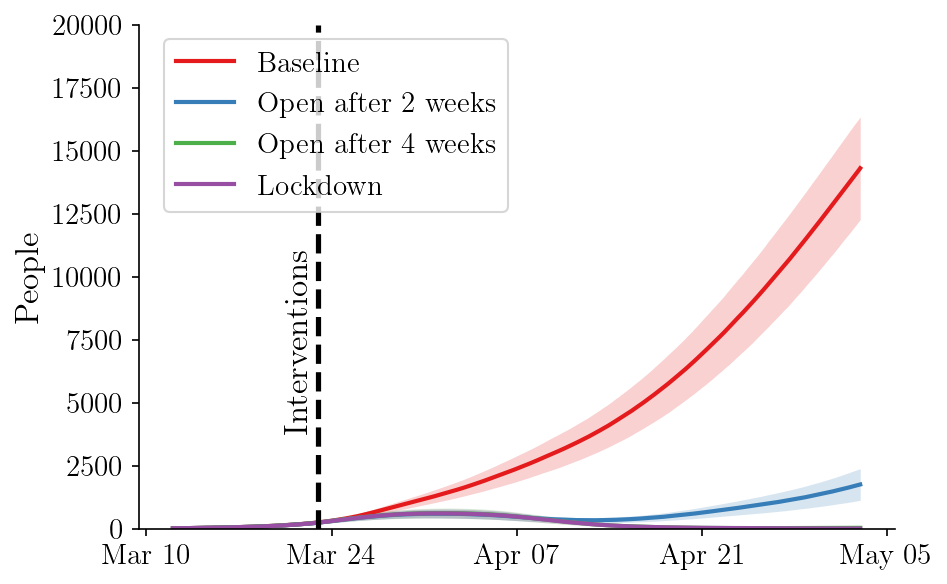

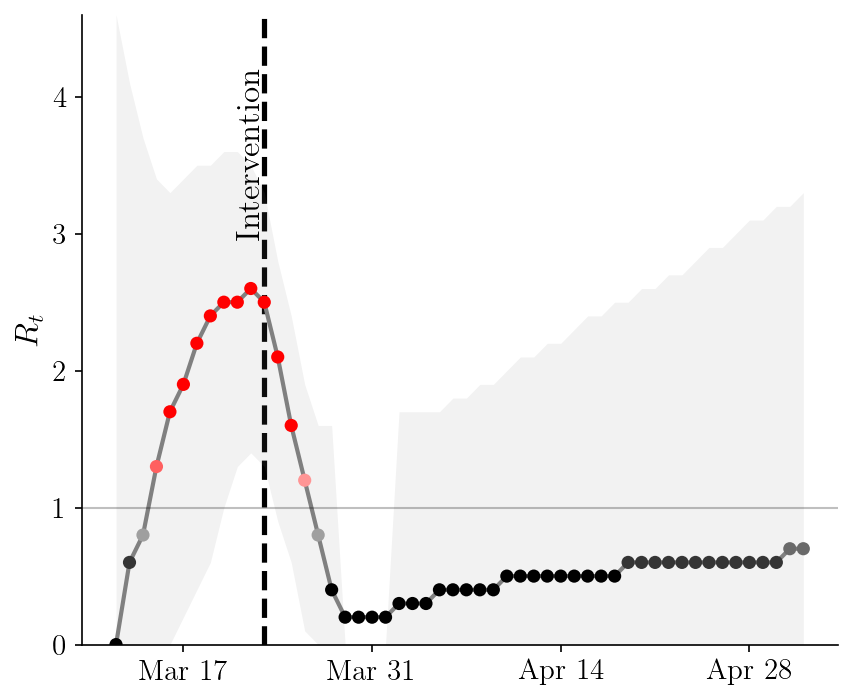

In [7]:
places = [('GER', 'TU')]
for country, area in places:
    print(country, area)
    plot_continued_lockdown(country, area, ymax_counterfactual, plot_rt=True)

## K groups

In [8]:
def plot_k_groups(country, area, ymax, plot_rt=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'k-groups-{country}-{area}' : [
            Plot(label='Baseline', 
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='K = 2',
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=2.pk')),
            Plot(label='K = 3',
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=3.pk')),
            Plot(label='K = 4', 
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=4.pk')),
        ],

    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[sims[0].country][sims[0].area]
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=ymax[sims[0].country][sims[0].area]/5,
            legendXoffset=0.015,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)
        
        
        if plot_rt:
            indices = [3]    # Show Rt for the best working strategy only
        
            for idx in indices:
                plot_name = sims[idx].experiment_info
                plotter.plot_daily_rts(summaries[idx], 
                                       filename=plot_name+'-Rt', 
                                       start_date=start_date, 
                                       titles=None, 
                                       lockdown_label='Intervention',
                                       lockdown_at=days_until_lockdown, 
                                       lockdown_label_y=3, 
                                       ymax=None, 
                                       errorevery=1, 
                                       )



GER TU
Optimize sigma using maximum likelihood estimation...
 0.50: 47
 0.50: 47
 0.01: 47
 0.01: 47
 0.47: 47
 0.47: 47
 0.28: 47
 0.28: 47
 0.39: 47
 0.39: 47
 0.34: 47
 0.34: 47
 0.36: 47
 0.36: 47
 0.36: 47
 0.36: 47
 0.36: 47
 0.36: 47
done. Best sigma found at: 0.36


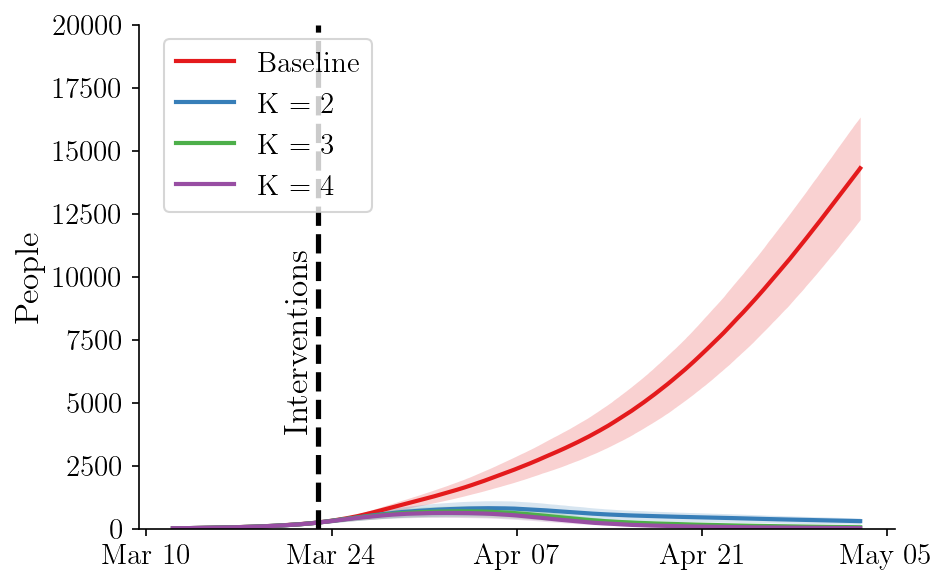

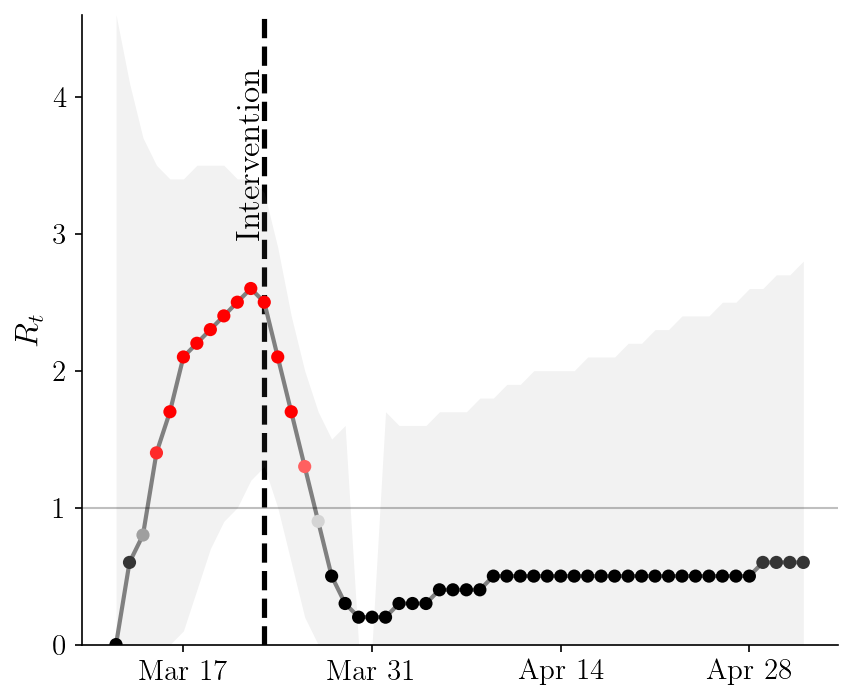

In [9]:
for country, area in places:
    print(country, area)
    plot_k_groups(country, area, ymax_counterfactual, plot_rt=True)

## Vulnerable Groups


In [10]:
def plot_vulnerable_groups(country, area, ymax, ymax_hosp):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'vulnerable-groups-{country}-{area}' : [
            Plot(label='Baseline',
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='Vulnerable groups', 
                path=(f'vulnerable-groups-{country}-{area}/'
                      f'vulnerable-groups-{country}-{area}-.pk')),
        ],

    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[sims[0].country][sims[0].area]
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=ymax[sims[0].country][sims[0].area]/5,
            legendXoffset=0.02,
            legendYoffset=0.02,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            ymax=ymax[sims[0].country][sims[0].area], 
            errorevery=14)

        plotter.compare_total_fatalities_and_hospitalizations(
            summaries, 
            titles=labels, 
            filename=plot_filename+ '-hosp', 
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legendXoffset=0.02,
            legendYoffset=0.02,
            legend_is_left=True,
            lockdown_at=days_until_lockdown,
            lockdown_label_y=ymax_hosp[sims[0].country][sims[0].area]/5,
            lockdown_label='Interventions',
            ymax=ymax_hosp[sims[0].country][sims[0].area], 
            errorevery=14)

GER TU


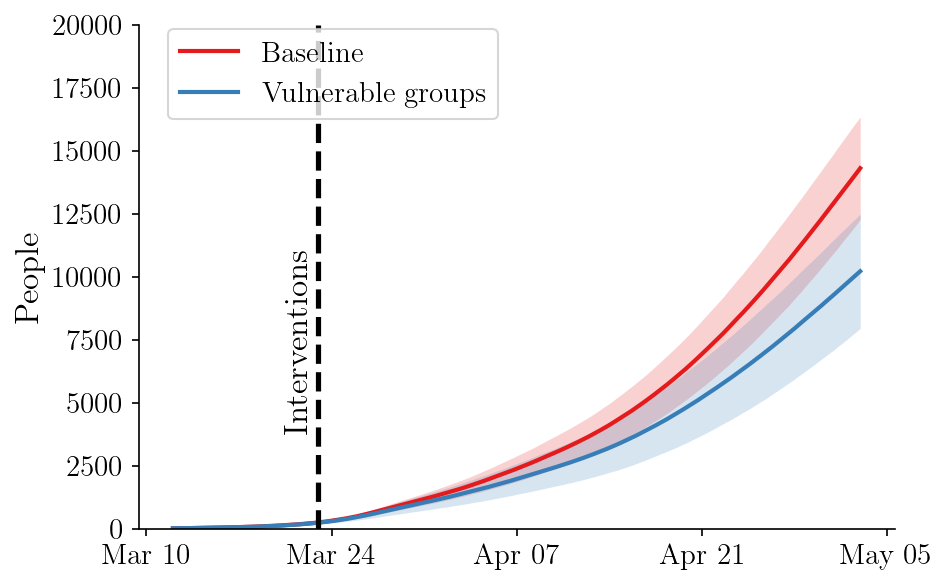

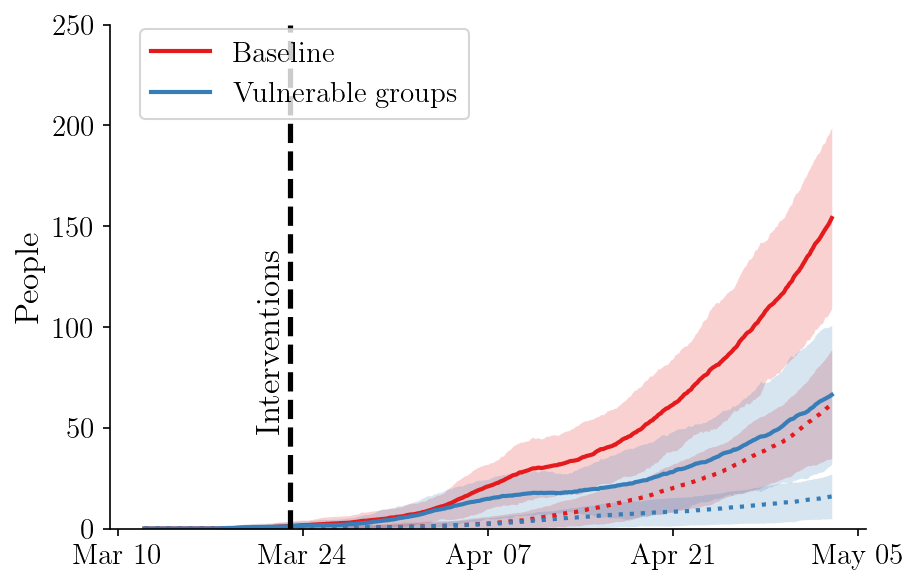

In [11]:
ymax_hosp = {
    'CH' : {'TI' : 150, 'BE': 1000, 'JU': 600},
    'GER': {'TU': 250, 'KL': 20, 'RH': 40}
}

for country, area in places:
    print(country, area)
    plot_vulnerable_groups(country, area, ymax_counterfactual, ymax_hosp)

### Contact tracing + Isolation

In [12]:
def plot_contact_tracing_isolation(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-{country}-{area}' : [
    #         Plot(label='baseline', 
    #             path=(f'baseline-scenario-b-{country}-{area}/'
    #                   f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='isolate+test, 48h delay, test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
            Plot(label='isolate+test, 48h delay, only test top 30 risk',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=30-test_policy=advanced.pk')),
            Plot(label='isolate only, 48h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=48.0-contacts_tested=None-test_policy=None.pk')),
            Plot(label='isolate only, 3h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=3.0-contacts_tested=None-test_policy=None.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename + '-single', 
            show_single_runs=3,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area],
            x_label_interval=3,
            errorevery=14)

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area],
            x_label_interval=3,
            errorevery=14)



In [ ]:
ymax = {
    'CH' : {'TI' : 150, 'JU': 500, 'BE': 500},
    'GER' : {'TU' : 400, 'KL': 500, 'RH': 500},
}

for country, area in places:
    print(country, area)
    plot_contact_tracing_isolation(country, area, ymax)

GER TU


### Efficiency of advanced testing policy

In [18]:
def plot_advanced_testing_policy(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-test-efficiency-{country}-{area}' : [
    #         Plot(label='baseline', 
    #             path=(f'baseline-scenario-b-{country}-{area}/'
    #                   f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='isolate+test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
            Plot(label='isolate+test top 30 risk',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=30-test_policy=advanced.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

    #     plotter.compare_total_infections(
    #         summaries, 
    #         titles=labels, 
    #         filename=plot_filename, 
    #         show_single_runs=False,
    #         start_date=start_date,
    #         figsize=(6,4), acc=500, 
    #         legend_is_left=True,
    #         legendXoffset=0.015,
    #         ymax=ymax[sims[0].country][sims[0].area] / 2, 
    #         errorevery=14)

        for summary, label in zip(summaries, labels):
            plotter.plot_daily_tested(
                summary, 
                title=label, 
                filename=plot_filename + '-' + label, 
                figsize=(6,4), acc=500, 
                ymax=ymax[sims[0].country][sims[0].area], 
                errorevery=50)





CH TI


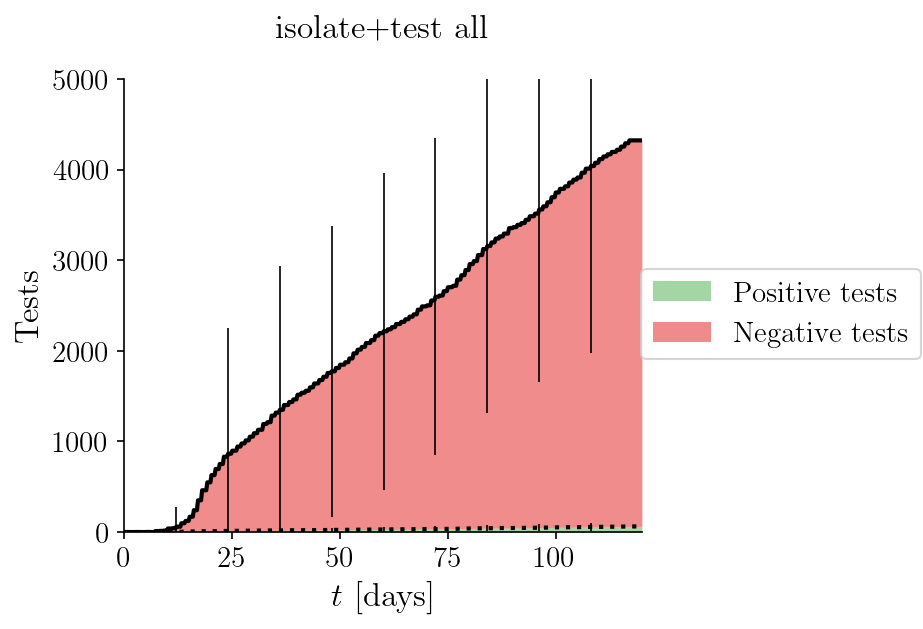

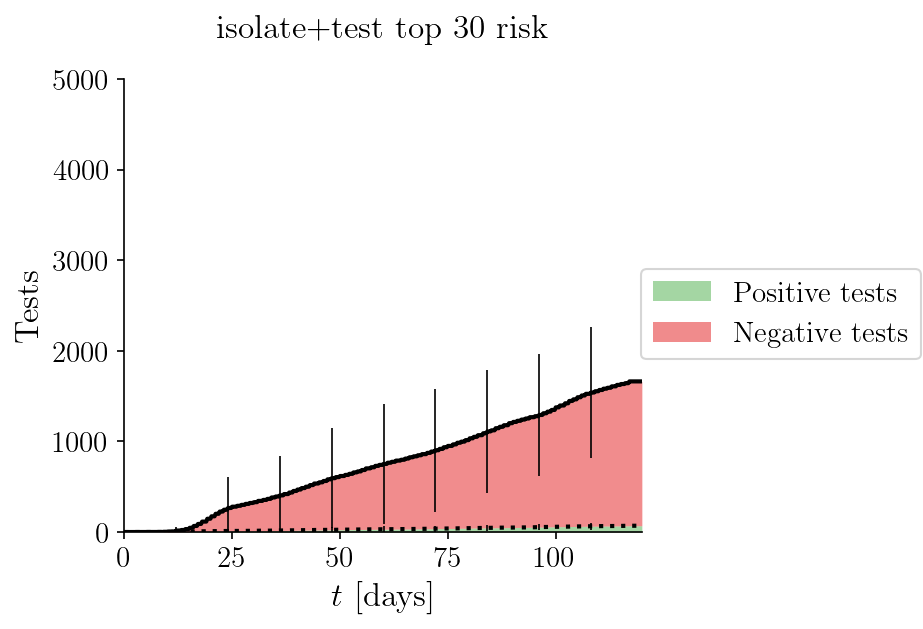

In [20]:
places = [('CH', 'TI')]

ymax = {
    'CH' : {'TI' : 5000},
    'GER' : {'TU' : 200}}

for country, area in places:
    print(country, area)
    plot_advanced_testing_policy(country, area, ymax)

### Contact tracing + Isolation Compliance

In [21]:
def plot_tracing_isolation_compliance(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-compliance-{country}-{area}' : [
            Plot(label='baseline', 
                path=(f'baseline-scenario-b-{country}-{area}/'
                      f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='25\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.25.pk')),
            Plot(label='50\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.5.pk')),
            Plot(label='65\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.65.pk')),
            Plot(label='75\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.75.pk')),
            Plot(label='100\% comp, isolate+test, 48h delay, test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename + '-single', 
            show_single_runs=5,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=1000,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area] * 1.5,
            x_label_interval=3,
            errorevery=14)

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_label_y=1000,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area],
            x_label_interval=3,
            errorevery=14)



CH TI
baseline-scenario-b-CH-TI/baseline-scenario-b-CH-TI-baseline.pk not found.
tracing-compliance-CH-TI/tracing-compliance-CH-TI-p=0.25.pk not found.
tracing-compliance-CH-TI/tracing-compliance-CH-TI-p=0.5.pk not found.
tracing-compliance-CH-TI/tracing-compliance-CH-TI-p=0.65.pk not found.
tracing-compliance-CH-TI/tracing-compliance-CH-TI-p=0.75.pk not found.


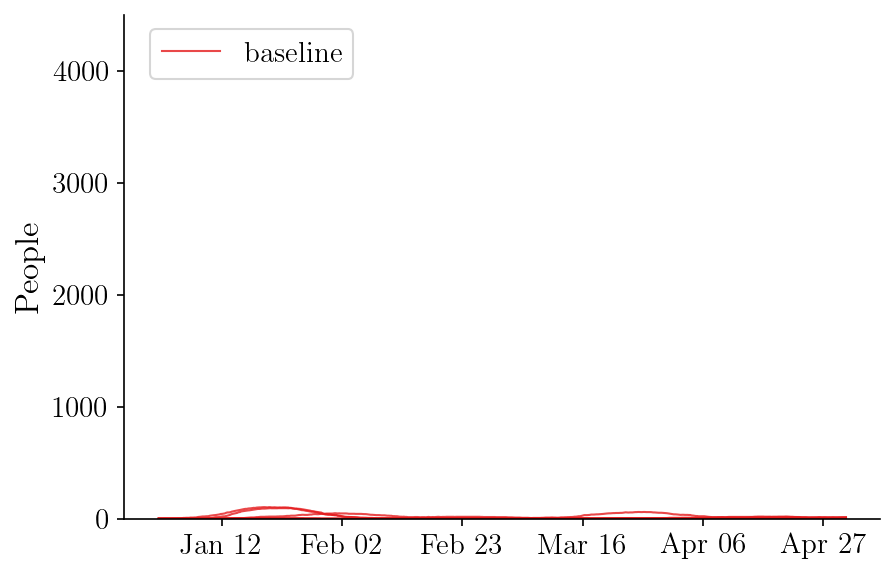

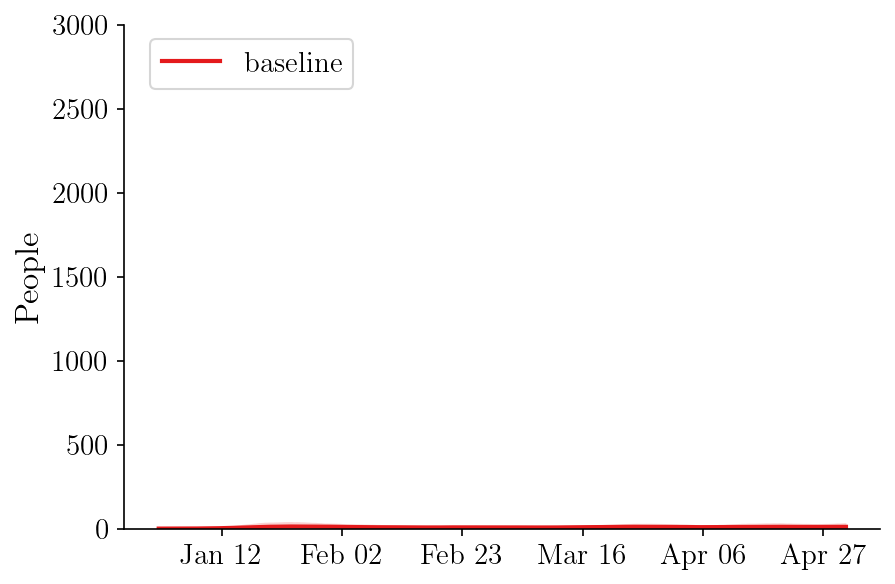

In [22]:
places = [('CH', 'TI')]
# country, area = 'GER', 'TU'

ymax = {
    'CH' : {'TI' : 3000},
    'GER' : {'TU' : 200},
}

for country, area in places:
    print(country, area)
    plot_tracing_isolation_compliance(country, area, ymax)

## Conditional Measures

In [23]:
def plot_conditional_measures(country, area, ymax, show_lockdowns=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'conditional-measures-scenario-b-{country}-{area}' : [
    #         Plot(label='Baseline', 
    #             path=(f'baseline-scenario-b-{country}-{area}/'
    #                   f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='conditional measures',
                path=(f'conditional-measures-scenario-b-{country}-{area}/'
                      f'conditional-measures-scenario-b-{country}-{area}-max_pos_tests_per_week_per_100k=50-initially_active=False.pk')),
        
    #    Plot(label='conditional measures',
    #            path=(f'conditional-measures-{country}-{area}/'
    #                  f'conditional-measures-{country}-{area}-max_pos_tests_per_week_per_100k=50-initially_active=False.pk')),
        ]
    }

    
    def get_lockdown_times(summary, country, area):
        TO_HOURS = 24.0
        start_date = calibration_start_dates[country][area]
        end_date = calibration_lockdown_dates[country]['end']
        measure_start_date = calibration_lockdown_dates[country]['start']
        measure_window_in_hours = dict()
        measure_window_in_hours['start'] = (pd.to_datetime(measure_start_date) - pd.to_datetime(start_date)).days * TO_HOURS
        measure_window_in_hours['end'] = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days * TO_HOURS

        interventions = []
        for ml in summary.measure_list:
            hist = list(ml.find(UpperBoundCasesBetaMultiplier, t=measure_window_in_hours['start']).intervention_history)
            lockdowns = [hist[0][:2]]
            j = 0
            for k in range(len(hist)):
                if k > j:
                    # If the time between two lock down periods is less than 2 days we count it as one lockdown\n",
                    if hist[k][0] - lockdowns[j][1] < 2 * 24.0:
                        lockdowns[j] = (lockdowns[j][0], hist[k][1])
                    else:
                        lockdowns.append(hist[k][0:2])
                        j += 1
            interventions.append(lockdowns)
        return interventions
    
    
    
    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')
        lockdowns = get_lockdown_times(summaries[0], country, area) if show_lockdowns else None
        
        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 


        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename + '-single', 
            show_single_runs=1,
            which_single_runs=5,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            lockdown_at=lockdowns,
            lockdown_label_y=ymax[sims[0].country][sims[0].area]/4,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area],
            x_label_interval=3,
            errorevery=14)

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area],
            x_label_interval=3,
            errorevery=14)


GER TU


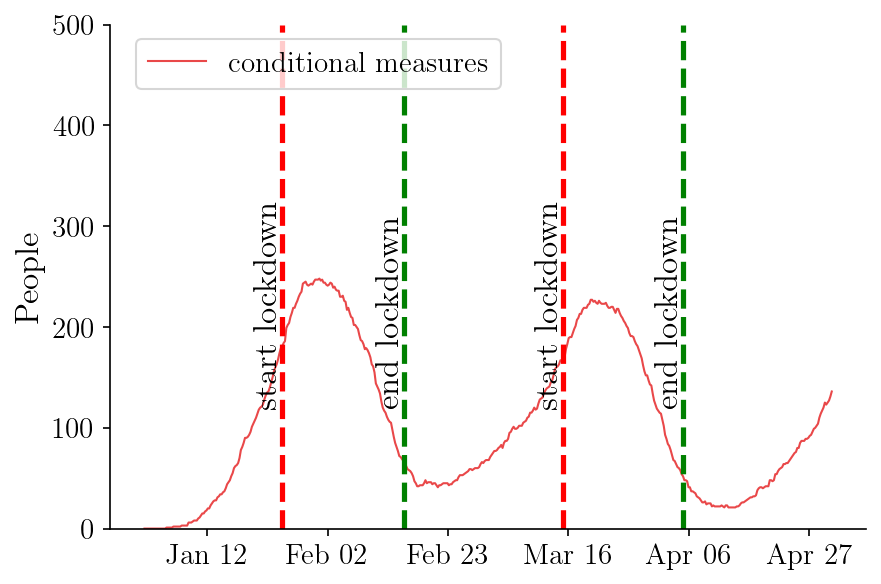

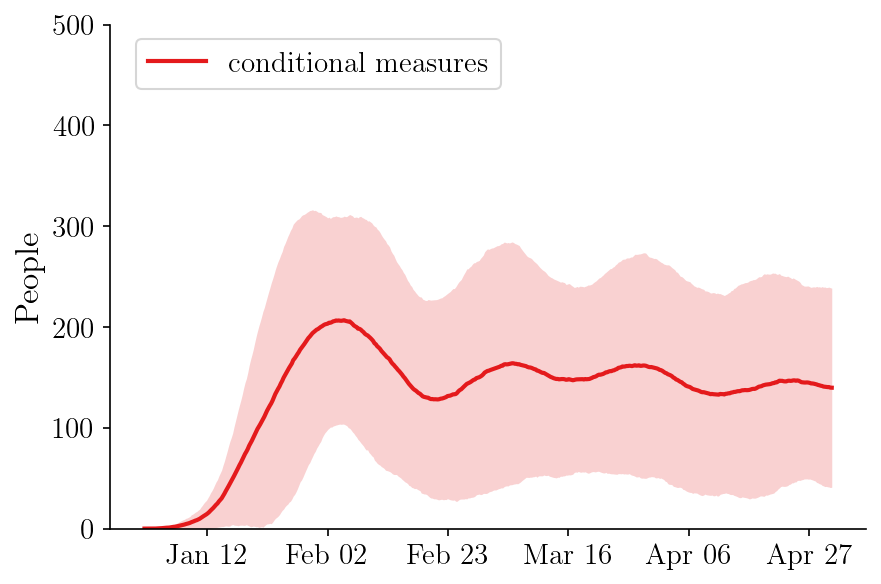

In [24]:
places = [('GER', 'TU')]

ymax = {
    'CH' : {'TI' : 200},
    'GER' : {'TU' : 500},
}

for country, area in places:
    print(country, area)
    plot_conditional_measures(country, area, ymax, show_lockdowns=True)

## Other experiment

In [ ]:
plots = {
    # tbd
}

## Narrowcasting Plot

In [ ]:
from lib.town_maps import MapIllustrator
from lib.settings.town_settings_tubingen import bbox

In [ ]:
day_start = 7
day_duration = 14

In [ ]:
# make sure to load a summary file that had `store_mob = True`
summary = load_summary(f'summary_file_with_mob.pk')

# plot
ill = MapIllustrator()
ill.marker_radius = 10.0
map_name = f'narrowcasting-plot-{day_start}-{day_duration}'

sitemap = ill.empirical_infection_probability_map(
    bbox=bbox, 
    site_loc=mob.site_loc, 
    site_type=mob.site_type, 
    site_dict=mob.site_dict, 
    map_name=map_name, 
    sim=summary, 
    t0=TO_HOURS * day_start, 
    t1=TO_HOURS * (day_start + day_duration), 
    delta=0.0, 
    r=0)

In [ ]:
sitemap